<a href="https://colab.research.google.com/github/kaal786/kaal786/blob/main/version1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Get Started

In [ ]:
import pandas as pd
import numpy as np
import pickle
import itertools
import gc
import math
import matplotlib.pyplot as plt
import dateutil.easter
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
from datetime import datetime, date
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, QuantileTransformer, LabelEncoder, minmax_scale
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression, HuberRegressor, SGDRegressor
from sklearn.svm import SVR, LinearSVR

In [ ]:
original_train_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle_/TimeSeries_/kaggle_tabular_2022/data/train.csv',index_col='row_id', parse_dates=['date'])
original_test_df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Kaggle_/TimeSeries_/kaggle_tabular_2022/data/test.csv',index_col='row_id',parse_dates=['date'])



In [ ]:
def smape_loss(y_true, y_pred):
    """SMAPE Loss to be used with TensorFlow"""
    return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200

###Feature Engineering

In [ ]:
def engineer(df):
    new_df = pd.DataFrame({'daynum': (df.date - datetime(2015,1,1)).dt.days,
                           'dayofyear': df.date.dt.dayofyear,
                           'wd1': df.date.dt.weekday == 1,
                           'wd2': df.date.dt.weekday == 2,
                           'wd3': df.date.dt.weekday == 3,
                           'wd4': df.date.dt.weekday == 4,
                           'wd5': df.date.dt.weekday == 5,
                           'wd6': df.date.dt.weekday == 6,
                           #'dec26': (df.date.dt.month == 12) & (df.date.dt.day == 29),
                           'dec27': (df.date.dt.month == 12) & (df.date.dt.day == 29),
                           'dec28': (df.date.dt.month == 12) & (df.date.dt.day == 29),
                           'dec29': (df.date.dt.month == 12) & (df.date.dt.day == 29),
                           'dec30': (df.date.dt.month == 12) & (df.date.dt.day == 30),
                           #'dec31': (df.date.dt.month == 12) & (df.date.dt.day == 30),
                           #'yearend': df.date.dt.dayofyear >= 360,
                           #'dec30': (df.date.dt.month == 12) & (df.date.dt.day == 30),
                           'easter': 0,
                           'easter1': 0,
                           'easter2': 0,
                           'easter3': 0,
                          })
    
    new_df['daynum2'] = np.log(new_df.daynum+80)

    # One-hot encoding (no need to encode the last categories)
    for country in ['Finland', 'Norway']:
        new_df[country] = df.country == country
    new_df['KaggleRama'] = df.store == 'KaggleRama'
    for product in ['Kaggle Mug', 'Kaggle Sticker']:
        new_df[product] = df['product'] == product
        
        
    # Seasonal variations (Fourier series)
    for k in range(1, 100):
        new_df[f'sin{k}'] = np.sin(new_df.dayofyear / 365 * 2 * math.pi * k)
        new_df[f'cos{k}'] = np.cos(new_df.dayofyear / 365 * 2 * math.pi * k)
        new_df[f'mug_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Mug']
        new_df[f'mug_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Mug']
        new_df[f'sticker_sin{k}'] = new_df[f'sin{k}'] * new_df['Kaggle Sticker']
        new_df[f'sticker_cos{k}'] = new_df[f'cos{k}'] * new_df['Kaggle Sticker']

    return new_df

In [ ]:
train_df = engineer(original_train_df)
train_df['date'] = original_train_df.date
train_df['num_sold'] = original_train_df.num_sold.astype(np.float32)
test_df = engineer(original_test_df)

In [ ]:
features = test_df.columns
for df in [train_df, test_df]:
    df[features] = df[features].astype(np.float32)
print(list(features))

['daynum', 'dayofyear', 'wd1', 'wd2', 'wd3', 'wd4', 'wd5', 'wd6', 'dec27', 'dec28', 'dec29', 'dec30', 'easter', 'easter1', 'easter2', 'easter3', 'daynum2', 'Finland', 'Norway', 'KaggleRama', 'Kaggle Mug', 'Kaggle Sticker', 'sin1', 'cos1', 'mug_sin1', 'mug_cos1', 'sticker_sin1', 'sticker_cos1', 'sin2', 'cos2', 'mug_sin2', 'mug_cos2', 'sticker_sin2', 'sticker_cos2', 'sin3', 'cos3', 'mug_sin3', 'mug_cos3', 'sticker_sin3', 'sticker_cos3', 'sin4', 'cos4', 'mug_sin4', 'mug_cos4', 'sticker_sin4', 'sticker_cos4', 'sin5', 'cos5', 'mug_sin5', 'mug_cos5', 'sticker_sin5', 'sticker_cos5', 'sin6', 'cos6', 'mug_sin6', 'mug_cos6', 'sticker_sin6', 'sticker_cos6', 'sin7', 'cos7', 'mug_sin7', 'mug_cos7', 'sticker_sin7', 'sticker_cos7', 'sin8', 'cos8', 'mug_sin8', 'mug_cos8', 'sticker_sin8', 'sticker_cos8', 'sin9', 'cos9', 'mug_sin9', 'mug_cos9', 'sticker_sin9', 'sticker_cos9', 'sin10', 'cos10', 'mug_sin10', 'mug_cos10', 'sticker_sin10', 'sticker_cos10', 'sin11', 'cos11', 'mug_sin11', 'mug_cos11', 'sticke

###Training

In [ ]:
def fit_model(X_tr, X_va=None):
    """Scale the data, fit a model, plot the training history and validate the model"""
    X_tr_f = X_tr[features]
    preproc = StandardScaler()
    X_tr_f = preproc.fit_transform(X_tr_f)
    y_tr = X_tr.num_sold.values.reshape(-1, 1)
    
    validation_data = None

    if X_va is not None:
        X_va_f = X_va[features]
        X_va_f = preproc.transform(X_va_f)
        y_va = X_va.num_sold.values.reshape(-1, 1)
        validation_data = (X_va_f, y_va)

    # Train and save the model
    model = HuberRegressor(epsilon=1.35) # 6.27316 5.62331 (1.35) ******************
    #model = LinearRegression() # 6.31480 5.73797
    model.fit(X_tr_f, np.log(y_tr))

    if X_va is not None:
        # Inference for validation after last epoch of fold
        y_va_pred = np.exp(model.predict(X_va_f)).reshape(-1, 1)
        print(y_va_pred.shape, oof_list[run][val_idx].shape)
        oof_list[run][val_idx] = y_va_pred

        # Evaluation
        smape = np.mean(smape_loss(y_va, y_va_pred))
        smape_q1 = np.mean(smape_loss(y_va, y_va_pred)[(X_va.date.dt.month <= 3).values])
        score_list.append((smape, datetime.now() - start_time))
        print(f"Fold {run}.{fold} | {str(datetime.now() - start_time)[-12:-7]}"
              f" | SMAPE: {smape:.5f} {smape_q1:.5f}")
        
        # Plot y_true vs. y_pred
        # Everything to the right of the black line is an outlier prediction which will be treated in a future version of the notebook
        plt.figure(figsize=(10, 10))
        plt.scatter(y_va, y_va_pred, s=1, color='r')
        plt.plot([0, plt.xlim()[1]], [0, plt.xlim()[1]], '--', color='k')
        if OUTLIERS != None:
            plt.plot([OUTLIERS, OUTLIERS+plt.ylim()[1]], [0, plt.ylim()[1]], color='k', lw=1)
        plt.gca().set_aspect('equal')
        plt.xlabel('y_true')
        plt.ylabel('y_pred')
        plt.title('OOF Predictions')
        plt.show()

        # Show the outliers among the predictions: Easter week, Pentecost week, last week of the year
        if OUTLIERS != None:
            print("Outlier predictions")
            print(original_train_df.iloc[val_idx][(y_va - y_va_pred > OUTLIERS).ravel()])
            #print("Outlier predictions")
            #print(X_va[(y_va_pred < 50).ravel()])
        
    return preproc, model


In [ ]:
# Make the results reproducible
np.random.seed(202100)

1
Fold 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(6552, 1) (6552, 1)
Fold 0.0 | 00:14 | SMAPE: 6.27313 5.62328


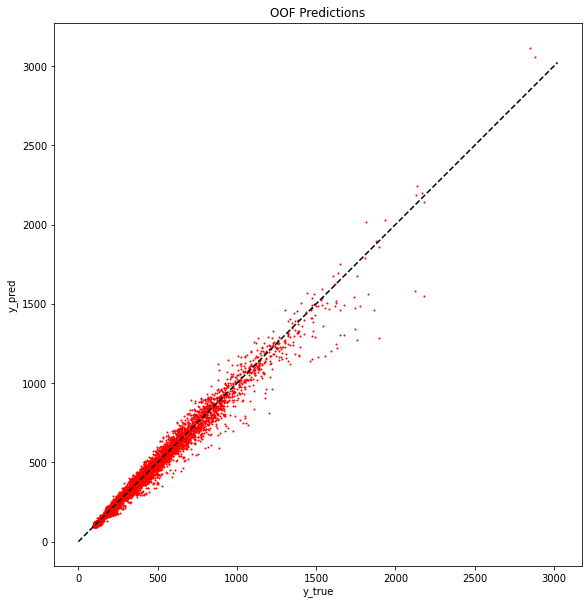

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#%%time
RUNS = 1 # should be 1. increase the number of runs only if you want see how the result depends on the random seed
INFERENCE = True
OUTLIERS = None

total_start_time = datetime.now()
score_list, test_pred_list, history_list = [], [], []
oof_list = [np.full((len(train_df), 1), -1.0, dtype='float32') for run in range(RUNS)]
print(len(oof_list))
for run in range(RUNS):
    fold = 0
    train_idx = np.arange(len(train_df))[train_df.date < datetime(2018, 1, 1)]
    val_idx = np.arange(len(train_df))[train_df.date > datetime(2018, 1, 1)]
    print(f"Fold {run}.{fold}")
    start_time = datetime.now()
    X_tr = train_df.iloc[train_idx]
    X_va = train_df.iloc[val_idx]
    
    preproc, model = fit_model(X_tr, X_va)

if INFERENCE:
    fold = 999
    train_idx = np.arange(len(train_df))
    X_tr = train_df.iloc[train_idx]
    
    preproc, model = fit_model(X_tr, None)

    # Inference for test
    test_pred_list.append(np.exp(model.predict(preproc.transform(test_df[features]))))

# Save all oof and test predictions to later determine ensemble weights
#with open('oof_list.pickle', 'wb') as handle: pickle.dump(oof_list, handle)
#with open('test_pred_list.pickle', 'wb') as handle: pickle.dump(test_pred_list, handle)
    
total_time = datetime.now() - total_start_time

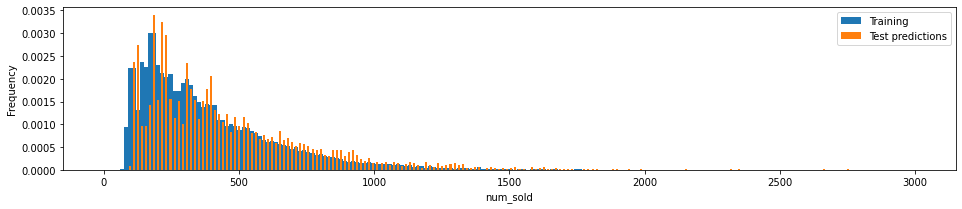

In [ ]:
if len(test_pred_list) > 0:
    # Create the submission file
    # sub = original_test_df[['row_id']].copy()
    sub=pd.DataFrame()
    sub['row_id']=original_test_df.index
    sub['num_sold'] = sum(test_pred_list) / len(test_pred_list)
    sub.to_csv('submission.csv', index=False)

    # Plot the distribution of the test predictions
    plt.figure(figsize=(16,3))
    plt.hist(train_df['num_sold'], bins=np.linspace(0, 3000, 201), density=True, label='Training')
    plt.hist(sub['num_sold'], bins=np.linspace(0, 3000, 201), density=True, rwidth=0.5, label='Test predictions')
    #plt.xticks(ticks=range(1, 8), labels=[f"{i}\n{(sub['Cover_Type'] == i).mean():.5f}" for i in range(1, 8)])
    plt.xlabel('num_sold')
    plt.ylabel('Frequency')
    #plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
    plt.legend()
    plt.show()